In [1]:
from neural_odes import *
%load_ext autoreload
%autoreload 2

## Solve the Discrete Lotka-Volterra Eqtn for general non-symmetric $A$
\begin{equation}
    \begin{aligned}
    p_i(t+1) &= p_i(t)\big[1+r_i\big(1-\frac{\sum_{j=1}^dA_{ij}p_j(t)}{k_i}\big)\big], i = 1, \dots d\\
    &= p_i(t)\big[1+r_i\big(1-\frac{\mathbf{b}_i^T\big(\sum_{j=1}^d\mathbf{c}_jp_j(t)\big)}{k_i}\big)\big], i = 1, \dots d \\
    &= p_i(t)\big[1+r_i\big(1-\frac{\mathbf{b}_i^TC\mathbf{p}}{k_i}\big)\big], i = 1, \dots d \\
    \end{aligned}
\end{equation}.

We approximate $A_{ij} = \mathbf{b}_i^T\mathbf{c}_j$ using the low rank matrix approximation $A= B^TC$, where $B = [\mathbf{b}_1, \cdots, \mathbf{b}_d] \in \mathbb{R}^{k \times d}$ and $C = [\mathbf{c}_1, \cdots, \mathbf{c}_d] \in \mathbb{R}^{k \times d}$.  Each $\mathbf{b}_i, \mathbf{c}_i \in \mathbb{R}^k$, where $k \ll d$ are the embeddings of time series $i$.

In matrix-vector form, we have $A\mathbf{p}$, which has computational complexity $\mathcal{O}(d^2)$ for $A \in \mathbb{R}^{d \times d}, \mathbf{p} \in \mathbb{R}^d$.  Using the low-rank form, we can write $A\mathbf{p} = B^T(C \mathbf{p})$.  We do not want to explicitly form the matrix $B^TC$, since this would have higher complexity of $\mathcal{O}(kd^2)$.  We instead break the computation into two matrix-vector products as indicated by the parathesis, each of complexity $\mathcal{O}(kd) \ll \mathcal{O}(d^2).$ 

We start with $d = 100$ for the number of time series and will learn the synthetic data from the equation for random initialized $A, \mathbf{r}, \mathbf{k}$

### Step 0. Set parameters

In [2]:
num_time_series = 100
num_time_steps = 10
low_rank_param = 5

To enable the symmetric form, where $C = B$, set `is_sym = True`.

To explicitly form the low rank matrix matrix product $A = B^TC$, set `is_full_matrix = True`.

In [3]:
is_sym = False
is_full_matrix = False

### Step 1. Generate data for $A \in \mathbb{R}^{d \times d}, \mathbf{r}, \mathbf{k} \in \mathbb{R}^d$ and the initial condition $\mathbf{p}(0) \in \mathbb{R}^d$.

In [4]:
# Use gpu and higher precision for numerical computations
ctx = mx.gpu()
dtype = 'float64'

In [5]:
_, _, p0, A = generate_data(num_time_series)
r = nd.ones(num_time_series, ctx=ctx, dtype=dtype)
k = 100*r
r.shape, k.shape, p0.shape, A.shape

((100,), (100,), (100,), (100, 100))

### Step 3. Solve the LV eqn for $p_i(t+1), 0 \le t < N - 1$.  We store $P$ as a matrix in $\mathbb{R}^{d \times N}$, whose first column is the initial condition $\mathbf{p}(0) \in \mathbb{R}^d$. Then $P = [\mathbf{p}(0), \dots, \mathbf{p}(N-1)].$  Use two embeddings to learn $B, C \in \mathbb{R}^{k \times d}$

In [6]:
neural_lv = NeuralLV(num_time_series, num_time_steps, low_rank_param, 
                     is_full_matrix, p0, r, k, A, is_sym)

In [7]:
# Set number of iterations to run
num_epochs = 5000

In [9]:
p_approx, p, A_approx, model= neural_lv.run(num_epochs)

In [15]:
# Can re run until convergence extra 1000 at a time (Ran twice for total of 7000 iterations)
p_approx, p, A_approx, model= neural_lv.run(model=model)

### Step 5. Error Evaluation and Plotting

In [16]:
print(f'l2 norm of the error = {nd.norm(p_approx-p)}')

l2 norm of the error = 
[0.08958898]
<NDArray 1 @gpu(0)>


In [17]:
print(f'max norm of the error = {nd.max(nd.abs(p_approx-p))}')

max norm of the error = 
[0.01711842]
<NDArray 1 @gpu(0)>


In [18]:
print(f'l2 matrix norm of the error of A and its low rank approx = {nd.norm(A_approx-A)}')

l2 matrix norm of the error of A and its low rank approx = 
[39.32629733]
<NDArray 1 @gpu(0)>


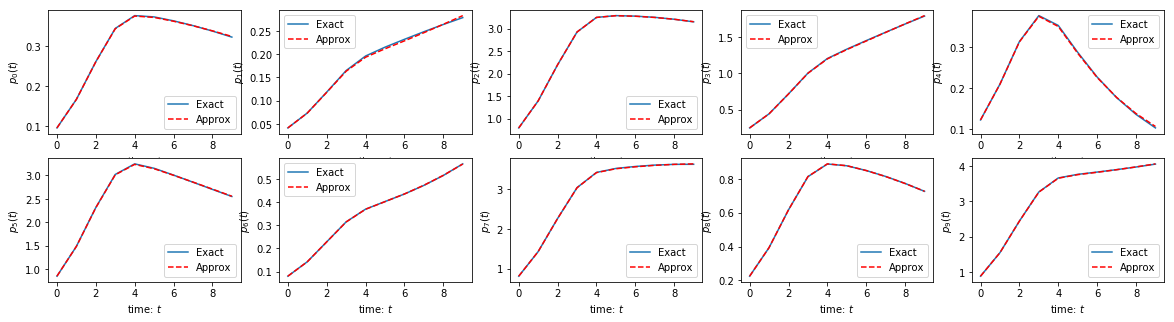

In [20]:
# First ten time series
lv_plot_ts(p, p_approx, fig_size_width=20)